In [1]:
# import necessary packages
!pip install -r requirements.txt/
!pip install wbdata
!pip install CFEDemands

import ndb
import pandas as pd
import warnings
from  scipy.optimize import linprog as lp
import numpy as np
import wbdata 

Could not open requirements file: [Errno 20] Not a directory: 'requirements.txt/'
  Using cached https://files.pythonhosted.org/packages/e1/d9/ef36cfd235c4c299e4a036e19e9c49c4e2a62e77b0eed6048246d7ca1c49/CFEDemands-0.1.6.3-py2.py3-none-any.whl


In [2]:
SHEETs = [# All Food
          ("https://docs.google.com/spreadsheet/ccc?key=1nkwKO01nDmLCHqiq4cE1N1LQYM-oNgrvhkwB92PCtE4","All"), 
         ]

## Minimum Cost Diet

In [3]:
import ndb
import pandas as pd
import warnings

DFs = []
#for csv in CSVs:  # Uncomment to use a list of csv files as inputs
#  DFs.append(pd.read_csv(csv,dtype=str))

try:
    if len(SHEETs):
        for ID, RANGE_NAME in SHEETs:
            try:
                if "docs.google.com" in ID:
                    sheet = "%s&output=csv" % ID
                else:
                    sheet = "https://docs.google.com/spreadsheet/ccc?key=%s&output=csv" % ID
                DFs.append(pd.read_csv(sheet))
            except ParserError:
                warnings.warn("Can't read sheet at https://docs.google.com/spreadsheets/d/%s.\nCheck Sharing settings, so that anyone with link can view?" % ID)
except NameError: # SHEETS not defined?
    pass

df = pd.concat(DFs,ignore_index=True,sort=False)
# Some columns which ought to be numeric are actually str; convert them
df['Price'] = df['Price'].astype(float)
df['Quantity'] = df['Quantity'].astype(float)
df["Units"] = df["Units"].astype(str)
df["Value"] = df["Value"].dropna().astype(int).astype(str)
df["NDB"][df['Food'].str.contains("Milk shakes and other dairy drinks")] = str("01110")
df["NDB"] = df["NDB"].dropna()

df

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Value,Food,Quantity,Units,Price,Date,Location,NDB,Notes,Unnamed: 9
0,1002,"Milk, whole",1.00,gallon,4.89,03/19/2019,Safeway - 94704,45287045,NaN,94704 zipcode
1,1004,"Milk, reduced fat",1.00,gallon,6.88,03/19/2019,Safeway,45243941,NaN,NaN
2,1006,"Milk, low fat",1.00,gallon,6.88,03/19/2019,Safeway,45243941,NaN,NaN
3,1008,"Milk, non fat",1.00,gallon,3.39,03/19/2019,Safeway,45340014,NaN,NaN
4,1202,"Flavored milk,whole",0.50,gallon,3.39,03/19/2019,Safeway,14177,Chocolate milk,NaN
5,1204,"Flavored milk, reduced fat",12.00,oz,1.99,03/19/2019,Safeway,45236702,NaN,NaN
6,1206,"Flavored milk, low fat",0.50,gallon,4.59,03/19/2019,Safeway,45289703,Chocolate milk,NaN
7,1402,Milk shakes and other dairy drinks,14.00,oz,3.00,03/19/2019,Safeway,01110,NaN,NaN
8,1404,Milk substitutes,64.00,oz,5.69,03/19/2019,Safeway,45325820,Organic coconut milk,NaN
9,1602,Cheese,32.00,oz,6.99,03/19/2019,Safeway,45102597,1 lb,NaN


In [4]:
values = df["Value"].tolist()
names = df["Food"].tolist()
value_name_dict = dict(zip(values,names))

In [5]:
user = "atwater"
apikey = {'atwater':"ekh9KVmwQxokFmje0yDKJsSdG5PCuxWpXphJMEB3"}
age_list = ["C 1-3", "F 4-8", "M 4-8", "F 9-13", "M 9-13", "F 14-18", "M 14-18", "F 19-30", "M 19-30",\
            "F 31-50", "M 31-50", "F 51+", "M 51+"]
#http://www.censusscope.org/us/chart_age.html
age_breakdown = [6.82, 3.56, 3.74, 3.56, 3.74, 3.49, 3.69, 6.71, 6.92,\
                15.32, 15.15, 15.01, 12.32]
    
    
import ndb
D = {}

for food in  df.Food.tolist():
    try:
        NDB = df.loc[df.Food==food,:].NDB
        D[food] = ndb.ndb_report(apikey[user],NDB).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find NDB Code %s for food %s." % (food,NDB))
        

D = pd.DataFrame(D,dtype=float)

D = D.reindex(sorted(D.columns), axis=1)

D

,Apple juice,Apples,Baby food: cereals,Baby food: fruit,Baby food: meat and dinners,Baby food: snacks and sweets,Baby food: vegetable,Bacon,Bagels and English muffins,Bananas,...,Tortillas,"Turkey, duck, other poultry",Turnovers and other grain-based items,Vegetable juice,Vegetable mixed dishes,"White potatoes, baked or boiled",Wine,Yeast breads,"Yogurt, low-fat and nonfat","Yogurt, whole and reduced fat"
Caffeine,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN
"Calcium, Ca",17.00,6.00,860.000,10.000,5.000,10.000,19.000,80.000,21.00,39.00,...,26.000,0.00,0.0,25.00,70.00,9.000,10.000,0.000,100.00,118.00
"Carbohydrate, by difference",46.67,14.29,83.140,13.600,2.430,13.600,5.230,1.890,53.68,67.50,...,46.510,3.57,75.0,5.83,26.29,15.540,3.800,42.860,9.33,14.12
Cholesterol,0.00,0.00,0.000,0.000,51.000,0.000,0.000,86.000,0.00,0.00,...,0.000,36.00,0.0,NaN,0.00,0.000,0.000,0.000,7.00,12.00
Energy,183.00,52.00,390.000,57.000,81.000,57.000,21.000,226.000,263.00,425.00,...,279.000,107.00,375.0,29.00,188.00,68.000,83.000,357.000,67.00,106.00
"Fatty acids, total monounsaturated",NaN,NaN,0.420,0.043,0.950,0.043,0.012,6.223,NaN,NaN,...,3.490,NaN,NaN,NaN,NaN,NaN,0.000,5.360,NaN,NaN
"Fatty acids, total polyunsaturated",NaN,NaN,0.784,0.046,0.160,0.046,0.148,4.699,NaN,NaN,...,1.160,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
"Fatty acids, total saturated",0.00,0.00,0.234,0.010,1.180,0.010,0.052,4.520,0.00,12.50,...,0.000,0.00,0.0,NaN,0.70,0.000,0.000,7.140,NaN,1.76
"Fatty acids, total trans",0.00,0.00,0.000,NaN,NaN,NaN,NaN,0.184,0.00,0.00,...,0.000,0.00,0.0,NaN,0.00,0.000,NaN,0.000,NaN,0.00
"Fiber, total dietary",0.00,3.20,1.300,1.200,0.000,1.200,2.300,NaN,3.20,10.00,...,7.000,0.00,0.0,NaN,2.80,2.700,0.000,0.000,0.70,0.00


In [6]:
# Convert food quantities to NDB units
df['NDB Quantity'] = df[['Quantity','Units']].T.apply(lambda x : ndb.ndb_units(x['Quantity'],x['Units']))

# Now may want to filter df by time or place--need to get a unique set of food names.
df['NDB Price'] = df['Price']/df['NDB Quantity']

df.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Prices = df.groupby('Food')['NDB Price'].min()

In [7]:
# Choose sex/age group:
group = "M 19-30"

# Define *minimums*
bmin = pd.read_csv('./diet_minimums.csv').set_index('Nutrition')[group]

# Define *maximums*
bmax = pd.read_csv('./diet_maximums.csv').set_index('Nutrition')[group]

In [8]:

from  scipy.optimize import linprog as lp
import numpy as np

tol = 1e-6 # Numbers in solution smaller than this (in absolute value) treated as zeros

c = Prices.apply(lambda x:x.magnitude).dropna()

# Compile list that we have both prices and nutritional info for; drop if either missing
use = list(set(c.index.tolist()).intersection(D.columns.tolist()))
c = c[use]

# Drop nutritional information for foods we don't know the price of,
# and replace missing nutrients with zeros.
Aall = D[c.index].fillna(0)

# Drop rows of A that we don't have constraints for.
Amin = Aall.loc[bmin.index]

Amax = Aall.loc[bmax.index]

# Minimum requirements involve multiplying constraint by -1 to make <=.
A = pd.concat([-Amin,Amax])

b = pd.concat([-bmin,bmax]) # Note sign change for min constraints

# Now solve problem!
result = lp(c, A, b, method='interior-point')

# Put back into nice series
diet = pd.Series(result.x,index=c.index)

print("Cost of diet for %s is $%4.2f per day." % (group,result.fun))
print("\nYou'll be eating (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.

tab = pd.DataFrame({"Outcome":np.abs(A).dot(diet),"Recommendation":np.abs(b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol].index.tolist())

Cost of diet for M 19-30 is $6.23 per day.

You'll be eating (in 100s of grams or milliliters):
Food
Pork                                0.080020
Crackers, excludes saltines         0.069618
Baby food: cereals                  1.012990
Ready-to-eat cereal, lower sugar    1.768461
Carrots                             7.093442
Tomatoes                            7.247020
Eggs and omelets                    0.000001
Bananas                             2.570417
dtype: float64

With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2600.000000          2400.0
Protein                           56.000000            56.0
Fiber, total dietary              78.673619            33.6
Folate, DFE                     2552.083610           400.0
Calcium, Ca                     2088.234999          1000.0
Carbohydrate, by difference      484.698277       

In [9]:
age_list = ["C 1-3", "F 4-8", "M 4-8", "F 9-13", "M 9-13", "F 14-18", "M 14-18", "F 19-30", "M 19-30",\
            "F 31-50", "M 31-50", "F 51+", "M 51+"]
lowest_price_diet = []
for age in age_list:
    group = age
    bmin = pd.read_csv('./diet_minimums.csv').set_index('Nutrition')[group]
    bmax = pd.read_csv('./diet_maximums.csv').set_index('Nutrition')[group]
    tol = 1e-6
    c = Prices.apply(lambda x:x.magnitude).dropna()
    use = list(set(c.index.tolist()).intersection(D.columns.tolist()))
    c = c[use]
    Aall = D[c.index].fillna(0)
    Amin = Aall.loc[bmin.index]
    Amax = Aall.loc[bmax.index]
    A = pd.concat([-Amin,Amax])
    b = pd.concat([-bmin,bmax])
    result = lp(c, A, b, method='interior-point')
    diet = pd.Series(result.x,index=c.index)
    lowest_price_diet.append(result.fun)
d = {'Age/Sex Group': age_list, 'Lowest Price Diet ($ / Day)': lowest_price_diet}
total_dataframe = pd.DataFrame(data=d)
total_dataframe = total_dataframe.set_index("Age/Sex Group")
total_dataframe["Population Percentage"] = age_breakdown
total_dataframe["Weighted Cost"] = total_dataframe["Population Percentage"].astype(float) / 100 * total_dataframe["Lowest Price Diet ($ / Day)"]

print("The average weighted minimum cost diet is $" + str(np.round(sum(total_dataframe["Weighted Cost"]),2)) +" per person")
total_dataframe


The average weighted minimum cost diet is $5.38 per person


,Lowest Price Diet ($ / Day),Population Percentage,Weighted Cost
Age/Sex Group,,,
C 1-3,3.325631,6.82,0.226808
F 4-8,3.920610,3.56,0.139574
M 4-8,3.888014,3.74,0.145412
F 9-13,4.502171,3.56,0.160277
M 9-13,4.468738,3.74,0.167131
F 14-18,5.420315,3.49,0.189169
M 14-18,5.825474,3.69,0.214960
F 19-30,5.207019,6.71,0.349391
M 19-30,6.232485,6.92,0.431288


## Regional Household Expenditures

In [10]:
all_households = pd.read_csv('faps_household_puf.csv', dtype=str)

In [11]:
northeast = all_households[all_households["region"] == "1"]
midwest = all_households[all_households["region"] == "2"]
south = all_households[all_households["region"] == "3"]
west = all_households[all_households["region"] == "4"]

In [12]:
hh_choice = pd.read_csv('faps_fafhnutrient_puf.csv', dtype=str)

In [13]:
hh_choice["food"] = hh_choice["usdafoodcat4"].map(value_name_dict)

In [14]:
hh_choice['gramstotal'] = hh_choice['gramstotal'].astype(float)

In [15]:
northeast_hh = hh_choice[hh_choice["hhnum"].isin(northeast["hhnum"])]
midwest_hh = hh_choice[hh_choice["hhnum"].isin(midwest["hhnum"])]
south_hh = hh_choice[hh_choice["hhnum"].isin(south["hhnum"])]
west_hh = hh_choice[hh_choice["hhnum"].isin(west["hhnum"])]

northeast_hh['gramstotal'] = northeast_hh['gramstotal'].astype(float)
midwest_hh['gramstotal'] = midwest_hh['gramstotal'].astype(float)
south_hh['gramstotal'] = south_hh['gramstotal'].astype(float)
west_hh['gramstotal'] = west_hh['gramstotal'].astype(float)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [16]:
import re
def numbers(value):
    return re.findall(r'\d+.\d+', value)
list_price = Prices.astype(str).apply(numbers)
def first_list(value):
    if len(value) >= 1:
        return float(value[0])
    else:
        return float(0)
corrected_prices = list_price.apply(first_list)

In [17]:
hh_stats = pd.read_csv('faps_individual_puf.csv', dtype=str)
hh_stats["hhnum"] = hh_stats["HHNUM"]
hh_stats_number_of_people = len(hh_stats)
hh_stats_average_number_days = np.average(hh_stats["INITFINALDAYS"].astype(float))

In [18]:
northeast_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(northeast["hhnum"])])
midwest_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(midwest["hhnum"])])
south_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(south["hhnum"])])
west_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(west["hhnum"])])

In [20]:
min_cost = ['filler']
regions = [hh_choice, northeast_hh, midwest_hh, south_hh, west_hh, min_cost]
values = []
households = []
number_of_people = []
monthly_income = []
measurement_time = []
for region in regions:
    if len(region) == 1:
        values.append(5.38)
        region = hh_choice
        food_df = pd.DataFrame()
        food_df["Foods"] = region.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])])
        monthly_income.append(np.average(all_households[all_households["hhnum"].isin(region["hhnum"])]['inchhavg_r'].astype(float)))
        households.append(len(hh_stats[hh_stats["hhnum"].isin(region["hhnum"])]["hhnum"].unique()))
        number_of_people.append(len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]))
        region['gramstotal'] = region['gramstotal'].astype(float)
        food_df["Price per Gram"] = corrected_prices / 100
        food_df["Amount Spent"] = food_df["Foods"] * food_df["Price per Gram"] 
        number_of_days = np.average(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]["INITFINALDAYS"].astype(int))
        measurement_time.append(number_of_days)
        food_df["Amount Spent Daily"] = food_df["Amount Spent"] / number_of_days
    else:
        food_df = pd.DataFrame()
        food_df["Foods"] = region.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])])
        households.append(len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]["hhnum"].unique()))
        monthly_income.append(np.average(all_households[all_households["hhnum"].isin(region["hhnum"])]['inchhavg_r'].astype(float)))
        number_of_people.append(len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]))
        region['gramstotal'] = region['gramstotal'].astype(float)
        food_df["Price per Gram"] = corrected_prices / 100
        food_df["Amount Spent"] = food_df["Foods"] * food_df["Price per Gram"] 
        number_of_days = np.average(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]["INITFINALDAYS"].astype(int))
        food_df["Amount Spent Daily"] = food_df["Amount Spent"] / number_of_days
        measurement_time.append(number_of_days)
        values.append(food_df["Amount Spent Daily"].sum())

values = np.round(values, 2)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
regions = ["Total", "Northeast", "Midwest", "South", "West", "Total Min Cost"]
total_df = pd.DataFrame()
total_df["Region"] = regions
total_df["Amount Spent Daily ($)"] = values
total_df["Number of Households"] = households
total_df["Number of People"] = number_of_people
ratio = [int(p) / int(h) for p,h in zip(number_of_people, households)]
ratio = np.round(ratio, 2)
total_df["Average People per Household"] = ratio
#total_df["Average length of Interview"] = measurement_time
total_df["Daily Income ($)"] = [np.round(int(p) / 30, 2) for p in monthly_income]
total_df["Proportion of Income Spent on Food (%)"] =  total_df["Amount Spent Daily ($)"] / total_df["Daily Income ($)"] * 100
total_df= total_df.set_index('Region')
total_df


,Amount Spent Daily ($),Number of Households,Number of People,Average People per Household,Daily Income ($),Proportion of Income Spent on Food (%)
Region,,,,,,
Total,5.84,4305,13078,3.04,130.53,4.474067
Northeast,5.87,717,2094,2.92,165.03,3.556929
Midwest,5.13,1058,2989,2.83,125.50,4.087649
South,6.92,1582,4722,2.98,112.10,6.173060
West,4.82,948,3273,3.45,140.90,3.420866
Total Min Cost,5.38,4305,13078,3.04,130.53,4.121658


In [22]:
white = hh_stats[hh_stats["RACECAT_R"] == "1"]
black = hh_stats[hh_stats["RACECAT_R"] == "2"]
american_indian = hh_stats[hh_stats["RACECAT_R"] == "3"]
asian = hh_stats[hh_stats["RACECAT_R"] == "4"]
other = hh_stats[hh_stats["RACECAT_R"] == "5"]
multiple = hh_stats[hh_stats["RACECAT_R"] == "6"]

white_hh = hh_choice[hh_choice["hhnum"].isin(white["hhnum"])]
black_hh = hh_choice[hh_choice["hhnum"].isin(black["hhnum"])]
american_indian_hh = hh_choice[hh_choice["hhnum"].isin(american_indian["hhnum"])]
asian_hh = hh_choice[hh_choice["hhnum"].isin(asian["hhnum"])]
other_hh = hh_choice[hh_choice["hhnum"].isin(other["hhnum"])]
multiple_hh = hh_choice[hh_choice["hhnum"].isin(multiple["hhnum"])]

white_hh['gramstotal'] = white_hh['gramstotal'].astype(float)
black_hh['gramstotal'] = black_hh['gramstotal'].astype(float)
american_indian_hh['gramstotal'] = american_indian_hh['gramstotal'].astype(float)
asian_hh['gramstotal'] = asian_hh['gramstotal'].astype(float)
other_hh['gramstotal'] = other_hh['gramstotal'].astype(float)
multiple_hh['gramstotal'] = multiple_hh['gramstotal'].astype(float)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [23]:
min_cost = ['filler']
races = [hh_choice, white_hh, black_hh, american_indian_hh, asian_hh, other_hh, multiple_hh]
values = []
households = []
monthly_income = []
number_of_people = []
measurement_time = []
for race in races:
    if len(region) == 1:
        values.append(1.38)
        race = hh_choice
        food_df = pd.DataFrame()
        food_df["Foods"] = race.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])])
        households.append(len(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])]["hhnum"].unique()))
        monthly_income.append(np.average(all_households[all_households["hhnum"].isin(race["hhnum"])]['inchhavg_r'].astype(float)))
        number_of_people.append(len(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])]))
        race['gramstotal'] = race['gramstotal'].astype(float)
        food_df["Price per Gram"] = corrected_prices / 100
        food_df["Amount Spent"] = food_df["Foods"] * food_df["Price per Gram"] 
        number_of_days = np.average(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])]["INITFINALDAYS"].astype(int))
        measurement_time.append(number_of_days)
        food_df["Amount Spent Daily"] = food_df["Amount Spent"] / number_of_days
    else:
        food_df = pd.DataFrame()
        food_df["Foods"] = race.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])])
        households.append(len(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])]["hhnum"].unique()))
        monthly_income.append(np.average(all_households[all_households["hhnum"].isin(race["hhnum"])]['inchhavg_r'].astype(float)))
        number_of_people.append(len(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])]))
        race['gramstotal'] = race['gramstotal'].astype(float)
        food_df["Price per Gram"] = corrected_prices / 100
        food_df["Amount Spent"] = food_df["Foods"] * food_df["Price per Gram"] 
        number_of_days = np.average(hh_stats[hh_stats["HHNUM"].isin(race["hhnum"])]["INITFINALDAYS"].astype(int))
        measurement_time.append(number_of_days)
        food_df["Amount Spent Daily"] = food_df["Amount Spent"] / number_of_days
        values.append(food_df["Amount Spent Daily"].sum())

values = np.round(values, 2)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
races = ["Total", "White", "Black", "American Indian", "Asian", "Other", "Multiple"]
total_df = pd.DataFrame()
total_df["Race"] = races
total_df["Amount Spent Daily ($)"] = values
total_df["Number of Households"] = households
total_df["Number of People"] = number_of_people
ratio = [int(p) / int(h) for p,h in zip(number_of_people, households)]
ratio = np.round(ratio, 2)
total_df["Average People per Household"] = ratio
#total_df["Average length of Interview"] = measurement_time
total_df["Daily Income ($)"] = [np.round(int(p) / 30, 2) for p in monthly_income]
total_df["Proportion of Income Spent on Food (%)"] =  total_df["Amount Spent Daily ($)"] / total_df["Daily Income ($)"] * 100
total_df= total_df.set_index('Race')
total_df


,Amount Spent Daily ($),Number of Households,Number of People,Average People per Household,Daily Income ($),Proportion of Income Spent on Food (%)
Race,,,,,,
Total,5.84,4305,13078,3.04,130.53,4.474067
White,6.20,3173,9521,3.00,136.07,4.556478
Black,5.33,719,2312,3.22,112.77,4.726434
American Indian,6.28,68,272,4.00,111.77,5.618681
Asian,5.13,223,671,3.01,168.40,3.046318
Other,4.49,434,1728,3.98,121.90,3.683347
Multiple,5.76,209,730,3.49,114.77,5.018733


## Nutritional Thresholds

In [25]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = hh_choice.groupby("food")["gramstotal"].sum() / len(hh_stats) / 100
hh_choice['gramstotal'] = hh_choice['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
results = np.abs(b).align(D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (All Locations):")
print(tab)



With the following nutritional outcomes of interest (All Locations):
                                    Outcome  Recommendations
Calcium, Ca                      853.852998           1000.0
Carbohydrate, by difference      504.437873            130.0
Energy                          3607.140324           2000.0
Energy                          3607.140324           2400.0
Fiber, total dietary              20.291109             28.0
Folate, DFE                       46.415761            400.0
Iron, Fe                          14.243133              8.0
Magnesium, Mg                     36.185722            420.0
Niacin                             3.264189             16.0
Phosphorus, P                    215.016017            700.0
Potassium, K                    1212.766106           4700.0
Protein                          115.252233             56.0
Riboflavin                         0.441973              1.3
Sodium, Na                      5684.769067           2300.0
Thiamin        

In [26]:
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]

In [27]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = northeast_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(northeast_hh["hhnum"])]) / 100
northeast_hh['gramstotal'] = northeast_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (Northeast):")
print(tab)


With the following nutritional outcomes of interest (Northeast):
                                    Outcome  Recommendations
Calcium, Ca                      894.295222           1000.0
Carbohydrate, by difference      583.786523            130.0
Energy                          4073.581235           2000.0
Energy                          4073.581235           2400.0
Fiber, total dietary              19.735285             28.0
Folate, DFE                       57.433030            400.0
Iron, Fe                          14.845028              8.0
Magnesium, Mg                     33.448808            420.0
Niacin                             3.149739             16.0
Phosphorus, P                    190.384470            700.0
Potassium, K                    1164.827567           4700.0
Protein                          120.631466             56.0
Riboflavin                         0.430524              1.3
Sodium, Na                      6066.375022           2300.0
Thiamin            

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = midwest_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(midwest_hh["hhnum"])]) / 100
midwest_hh['gramstotal'] = midwest_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (Midwest):")
print(tab)


With the following nutritional outcomes of interest (Midwest):
                                    Outcome  Recommendations
Calcium, Ca                     1019.486305           1000.0
Carbohydrate, by difference      602.360635            130.0
Energy                          4316.408269           2000.0
Energy                          4316.408269           2400.0
Fiber, total dietary              22.752755             28.0
Folate, DFE                       62.975037            400.0
Iron, Fe                          15.904424              8.0
Magnesium, Mg                     42.249994            420.0
Niacin                             4.076113             16.0
Phosphorus, P                    262.593169            700.0
Potassium, K                    1365.282868           4700.0
Protein                          134.029568             56.0
Riboflavin                         0.556170              1.3
Sodium, Na                      6864.913984           2300.0
Thiamin              

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = south_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(south_hh["hhnum"])]) / 100
south_hh['gramstotal'] = south_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (South):")
print(tab)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



With the following nutritional outcomes of interest (South):
                                    Outcome  Recommendations
Calcium, Ca                      983.945161           1000.0
Carbohydrate, by difference      538.386948            130.0
Energy                          3910.887767           2000.0
Energy                          3910.887767           2400.0
Fiber, total dietary              23.375448             28.0
Folate, DFE                       50.354734            400.0
Iron, Fe                          16.674302              8.0
Magnesium, Mg                     41.994073            420.0
Niacin                             3.959248             16.0
Phosphorus, P                    250.200644            700.0
Potassium, K                    1487.959788           4700.0
Protein                          132.488943             56.0
Riboflavin                         0.501715              1.3
Sodium, Na                      6373.012463           2300.0
Thiamin                

In [30]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = west_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(west_hh["hhnum"])]) / 100
west_hh['gramstotal'] = west_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (West):")
print(tab)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



With the following nutritional outcomes of interest (West):
                                    Outcome  Recommendations
Calcium, Ca                      812.259566           1000.0
Carbohydrate, by difference      506.223326            130.0
Energy                          3588.265373           2000.0
Energy                          3588.265373           2400.0
Fiber, total dietary              21.630085             28.0
Folate, DFE                       36.132676            400.0
Iron, Fe                          14.225196              8.0
Magnesium, Mg                     37.717058            420.0
Niacin                             2.828833             16.0
Phosphorus, P                    217.959308            700.0
Potassium, K                    1166.222672           4700.0
Protein                          113.424002             56.0
Riboflavin                         0.426128              1.3
Sodium, Na                      5521.923826           2300.0
Thiamin                 

## Demand Estimation Cleaning

In [31]:
hh_choice['gramstotal'] = hh_choice['gramstotal'].astype(float)

In [32]:
households = all_households["hhnum"].tolist()
regions = all_households["region"].tolist()
household_region_dict = dict(zip(households,regions))

In [33]:
hh_choice["region"] = hh_choice["hhnum"].map(household_region_dict)

In [34]:
grouped = hh_choice.groupby(["hhnum","region", "food"])["gramstotal"].sum().unstack('food')
grouped = grouped.reset_index().rename_axis(None, axis=1)
grouped.insert(1, "year", [2013] * len(grouped))
grouped = grouped.rename(index=str, columns={"hhnum": "j", "year": "t", "region": "m"})

## Household Data

In [159]:
hh_stats = pd.read_csv('faps_individual_puf.csv', dtype=str)

In [160]:
hh_stats = pd.read_csv('faps_individual_puf.csv', dtype=str)
hh_stats = hh_stats[["HHNUM", "SEX", "AGE_R"]]
hh_stats = hh_stats[hh_stats["AGE_R"] != 'D']
hh_stats['AGE_R'] = hh_stats['AGE_R'].astype(float)
def men_function(x):
    if float(x["AGE_R"]) >= 18 and x["SEX"] == '1':
        return 1
    return 0
def boy_function(x):
    if float(x["AGE_R"]) < 18 and x["SEX"] == '1':
        return 1
    return 0
def women_function(x):
    if float(x["AGE_R"]) >= 18 and x["SEX"] == '2':
        return 1
    return 0
def girl_function(x):
    if float(x["AGE_R"]) < 18 and x["SEX"] == '2':
        return 1
    return 0
#hh_stats["ADULT"] = hh_stats["AGE_R"].apply(over_eighteen)
hh_stats["Men"] = hh_stats.apply(men_function, axis=1)
hh_stats["Women"] = hh_stats.apply(women_function, axis=1)
hh_stats["Boys"] = hh_stats.apply(boy_function, axis=1)
hh_stats["Girls"] = hh_stats.apply(girl_function, axis=1)


hh_stats.head(30)

,HHNUM,SEX,AGE_R,Men,Women,Boys,Girls
0,100012,1,47.5,1,0,0,0
1,100012,2,47.5,0,1,0,0
2,100012,1,27.5,1,0,0,0
3,100012,2,13.5,0,0,0,1
4,100012,1,9.5,0,0,1,0
5,100015,1,62.5,1,0,0,0
6,100024,2,47.5,0,1,0,0
7,100024,1,16.5,0,0,1,0
8,100026,2,27.5,0,1,0,0
9,100026,1,27.5,1,0,0,0


In [161]:
def household_size(x):
    return np.log(x["Men"] + x["Women"] + x["Boys"] + x["Girls"])

In [162]:
hh_stats = hh_stats[["HHNUM", "Men", "Women", "Boys", "Girls"]]
hh_stats_grouped = hh_stats.groupby("HHNUM").sum().reset_index()
region_col = hh_stats_grouped["HHNUM"].map(household_region_dict)
hh_stats_grouped.insert(1, "region", region_col)
hh_stats_grouped.insert(1, "year", [2013] * len(hh_stats_grouped))
hh_stats_grouped["logHsize"] = hh_stats_grouped.apply(household_size, axis=1)
hh_stats_grouped = hh_stats_grouped.rename(index=str, columns={"HHNUM": "j", "year": "t", "region": "m"})
hh_stats_grouped

,j,t,m,Men,Women,Boys,Girls,logHsize
0,100012,2013,3,2,1,1,1,1.609438
1,100015,2013,3,1,0,0,0,0.000000
2,100024,2013,2,0,1,1,0,0.693147
3,100026,2013,3,2,1,0,0,1.098612
4,100028,2013,1,3,2,1,1,1.945910
5,100031,2013,1,1,1,0,0,0.693147
6,100040,2013,3,1,1,0,0,0.693147
7,100049,2013,2,3,0,0,0,1.098612
8,100053,2013,3,1,1,0,0,0.693147
9,100054,2013,4,1,1,2,0,1.386294


In [163]:
import pandas as pd
import numpy as np

x = grouped

# Change 'ICRISAT' to key of your own sheet in Sheets, above
z = hh_stats_grouped

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1

# Take logs of expenditures; call this y
y = np.log(x.replace(0,np.nan).set_index(['j','t','m']))

z.set_index(['j','t','m'],inplace=True)

In [164]:
z.head()

,,,Men,Women,Boys,Girls,logHsize
j,t,m,,,,,
100012,2013,1,2,1,1,1,1.609438
100015,2013,1,1,0,0,0,0.000000
100024,2013,1,0,1,1,0,0.693147
100026,2013,1,2,1,0,0,1.098612
100028,2013,1,3,2,1,1,1.945910


In [165]:
y.head()

,,,Apple juice,Apples,Baby food: cereals,Baby food: fruit,Baby food: meat and dinners,Baby food: snacks and sweets,Baby food: vegetable,Bacon,Bagels and English muffins,Bananas,...,Tortillas,"Turkey, duck, other poultry",Turnovers and other grain-based items,Vegetable juice,Vegetable mixed dishes,"White potatoes, baked or boiled",Wine,Yeast breads,"Yogurt, low-fat and nonfat","Yogurt, whole and reduced fat"
j,t,m,,,,,,,,,,,,,,,,,,,,,
100012,2013,1,7.306103,4.735231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.699902,NaN,NaN,NaN,NaN
100015,2013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.300696,NaN,NaN
100024,2013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.852202,NaN,NaN,NaN
100026,2013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.093074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100028,2013,1,4.908208,4.735231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.897705,NaN,NaN,NaN,NaN,NaN


In [166]:
import cfe

result = cfe.Result(y=y,z=z)

result

<xarray.Result>
Dimensions:           (i: 142, j: 4826, k: 5, m: 1, t: 1)
Coordinates:
  * j                 (j) object '100012' '100015' ... '120078' '120080'
  * t                 (t) int64 2013
  * m                 (m) int64 1
  * i                 (i) <U48 'Apple juice' ... 'Yogurt, whole and reduced fat'
  * k                 (k) <U8 'Men' 'Women' 'Boys' 'Girls' 'logHsize'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 2.0 1.0 0.0 2.0 ... 0.0 0.6931 0.0
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y         

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [167]:
result.get_reduced_form()

/srv/app/venv/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


After running this we can examine the estimated coefficients $\delta$:



In [168]:
result.delta.to_dataframe().unstack('k')

delta            \
k                                                     Boys     Girls   
i                                                                      
Apple juice                                       0.023821 -0.041489   
Apples                                            0.166360  0.217807   
Bananas                                           0.066127  0.082774   
Beans, peas, legumes                             -0.049464 -0.118486   
Beef, excludes ground                            -0.010991 -0.083466   
Biscuits, muffins, quick breads                  -0.030903 -0.007879   
Bottled water                                    -0.064942  0.119683   
Burgers                                           0.033916  0.044303   
Burritos and tacos                               -0.033694  0.021882   
Cakes and pies                                    0.013985 -0.056783   
Candy containing chocolate                       -0.167804 -0.025532   
Candy not containing chocolate                    0.114485  0.015842   
Carrots                                           0.183989  0.161869   
Cheese                                           -0.065937 -0.007104   
Chicken patties, nuggets and tenders              0.064560  0.051119   
Chicken, whole pieces                            -0.094349 -0.145414   
Chicken/turkey sandwiches                        -0.020664 -0.100190   
Citrius fruits                                    0.122667  0.075645   
Citrus juice                                      0.078067  0.053038   
Coffee                                           -0.062575  0.003277   
Cookies and brownies                              0.083953  0.052666   
Corn                                             -0.021516 -0.106788   
Diet soft drinks                                 -0.099739 -0.024387   
Dips, gravies, other sauces                      -0.112303 -0.167596   
Doughnuts, sweet rolls, pastries                 -0.044310 -0.081060   
Egg/breakfast sandwiches                         -0.043799  0.006045   
Eggs and omelets                                 -0.074281 -0.005195   
Fish                                             -0.132656 -0.091989   
Flavored milk, reduced fat                        0.012650  0.015044   
French fries and other fried potatoes            -0.016734 -0.019695   
...                                                    ...       ...   
Milk, reduced fat                                 0.032643 -0.040477   
Nachos                                            0.139504  0.171986   
Other fruit juice                                 0.036212  0.023116   
Other fruits and fruit salads                    -0.075808 -0.076694   
Other mexican mixed dishes                        0.114791  0.081147   
Other sandwiches                                  0.010786 -0.032669   
Other vegetables and combinations                 0.005902  0.033860   
Pancakes, waffles, French Toast                   0.055160 -0.042676   
Pasta mixed dishes, excludes macaroni and cheese  0.072012  0.079553   
Pizza                                             0.029799  0.000810   
Potato chips                                      0.131872  0.086371   
Poultry mixed dishes                             -0.092027 -0.049316   
Pretzels / snack mix                              0.023265  0.081412   
Read to eat cereal, higher sugar                  0.024091 -0.015511   
Rice                                              0.008620 -0.032671   
Rice mixed dishes                                -0.131635 -0.012977   
Rolls and buns                                   -0.072566 -0.158016   
Salad dressings and vegetable oils                0.123758  0.046159   
Sausages                                         -0.081526 -0.083825   
Soft drinks                                       0.027753  0.054186   
Soups                                             0.049379 -0.007540   
Sports and energy drinks                         -0.085374 -0.061110   
Stir-fry and soy-base

Also the good-time constants $a_{it}$:



In [169]:
result.a.to_dataframe().unstack('i')

a                                           \
i      Apple juice    Apples   Bananas Beans, peas, legumes   
t    m                                                        
2013 1     5.49242  5.293585  5.242345             5.113197   

                                                                            \
i      Beef, excludes ground Biscuits, muffins, quick breads Bottled water   
t    m                                                                       
2013 1              5.180023                        4.679971       6.63284   

                                                       ...                 \
i        Burgers Burritos and tacos Cakes and pies     ...          Soups   
t    m                                                 ...                  
2013 1  5.450026           6.022184       5.006713     ...       5.924253   

                                                                       \
i      Sports and energy drinks Stir-fry and soy-based sauce mixtures   
t    m                                                                  
2013 1                 6.877546                              5.384194   

                                                                        \
i      String beans Tap water      Tea Tortilla, corn, and other chips   
t    m                                                                   
2013 1     4.574388  6.797675  6.95918                        4.164148   

                                                                            
i      Vegetable mixed dishes White potatoes, baked or boiled Yeast breads  
t    m                                                                      
2013 1               5.374691                        5.019324     4.494931  

[1 rows x 68 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [170]:
result.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).head(10)

,beta
i,
Sausages,1.165560
Yeast breads,1.079550
"Milk, reduced fat",0.967453
"Beef, excludes ground",0.959621
"Jams, syrups, toppings",0.931565
"White potatoes, baked or boiled",0.906833
Cheese,0.900340
"Beans, peas, legumes",0.863985
"Read to eat cereal, higher sugar",0.850354


That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)

Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



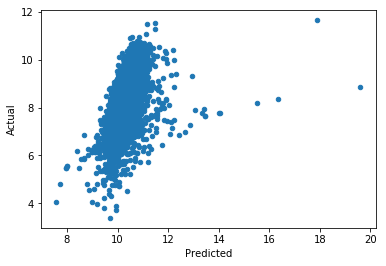

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

result.get_predicted_log_expenditures()

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

### Holding Households Constant

In [172]:
house_result = result

In [173]:
house_result['z'] = house_result['z'] * 0

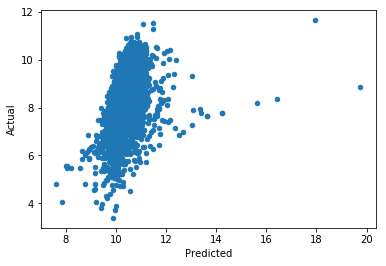

In [174]:
house_result.get_predicted_log_expenditures()

x = house_result.y.sum('i').to_dataframe().squeeze()
xhat = house_result.yhat.sum('i').to_dataframe().squeeze()

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

xhat = house_result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

## Engle's Law

In [175]:
result = cfe.Result(y=y,z=z)

/srv/app/venv/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


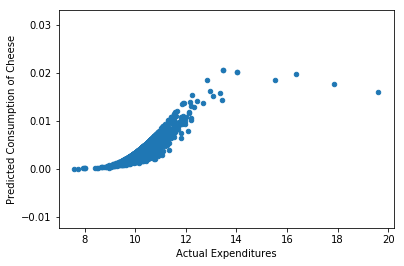

In [176]:
result.get_predicted_log_expenditures()

cheese=result.get_predicted_expenditures().sel(i='Cheese',t=2013,m=1)
xbar = result.get_predicted_expenditures().sel(t=2013,m=1).sum('i')

wcheese = cheese/xbar

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual Expenditures':np.log(xbar),'Predicted Consumption of Cheese':wcheese})

df.plot.scatter(x='Actual Expenditures',y='Predicted Consumption of Cheese')

/srv/app/venv/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


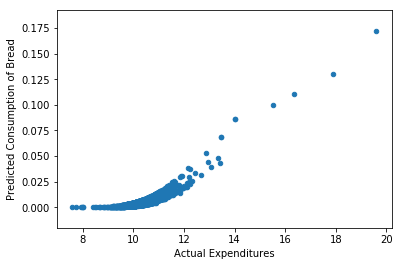

In [177]:
result.get_predicted_log_expenditures()

bread=result.get_predicted_expenditures().sel(i='Yeast breads',t=2013,m=1)
xbar = result.get_predicted_expenditures().sel(t=2013,m=1).sum('i')

wbread = bread/xbar

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual Expenditures':np.log(xbar),'Predicted Consumption of Bread':wbread})

df.plot.scatter(x='Actual Expenditures',y='Predicted Consumption of Bread')

/srv/app/venv/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


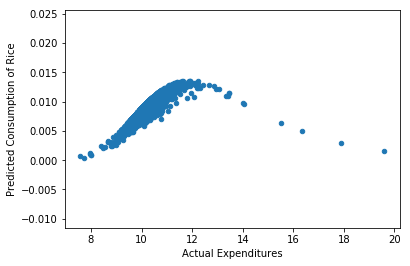

In [181]:
result.get_predicted_log_expenditures()

rice=result.get_predicted_expenditures().sel(i='Rice',t=2013,m=1)
xbar = result.get_predicted_expenditures().sel(t=2013,m=1).sum('i')

wrice = rice/xbar

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual Expenditures':np.log(xbar),'Predicted Consumption of Rice':wrice})

df.plot.scatter(x='Actual Expenditures',y='Predicted Consumption of Rice')

/srv/app/venv/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


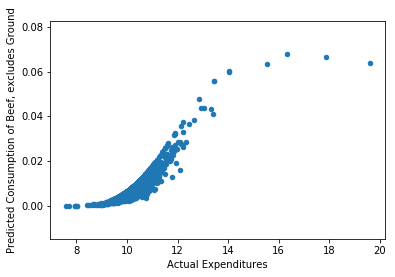

In [189]:
result.get_predicted_log_expenditures()

beef=result.get_predicted_expenditures().sel(i='Beef, excludes ground',t=2013,m=1)
xbar = result.get_predicted_expenditures().sel(t=2013,m=1).sum('i')

wbeef = beef/xbar

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual Expenditures':np.log(xbar),'Predicted Consumption of Beef, excludes Ground':wbeef})

df.plot.scatter(x='Actual Expenditures',y='Predicted Consumption of Beef, excludes Ground')